In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)   
pd.set_option('display.float_format', lambda x: '%.5f' % x)  
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import MultipleLocator
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import joblib
import scipy.stats
from time import *
from tqdm import tnrange, tqdm_notebook
from time import sleep
from matplotlib.mathtext import _mathtext as mathtext
mathtext.FontConstantsBase.sup1 = 0.3 

In [7]:
nh3 = pd.read_excel('./df_training.xlsx')

In [21]:
for i in range(1, len(nh3['Fertilizer type'].unique()) + 1) :
    nh3[nh3['Fertilizer type'].unique()[i - 1]] = np.array(nh3['Fertilizer type'] == nh3['Fertilizer type'].unique()[i - 1]).astype(np.int32)
    i += 1
del nh3['Fertilizer type']

In [22]:
for i in range(1, len(nh3['Nitrogen placement'].unique()) + 1) :
    nh3[nh3['Nitrogen placement'].unique()[i - 1]] = np.array(nh3['Nitrogen placement'] == nh3['Nitrogen placement'].unique()[i - 1]).astype(np.int32)
    i += 1
del nh3['Nitrogen placement']

In [23]:
nh3['Number of fertilizer applications'] = [1 if x >= 2 else 0 for x in nh3['Number of fertilizer applications']]

In [24]:
nh3['Soil tillage practices'] = [1 if x=='NT' else 0 for x in nh3['Soil tillage practices']]

In [25]:
for i in range(1, len(nh3['Crop type'].unique()) + 1) :
    nh3[nh3['Crop type'].unique()[i - 1]] = np.array(nh3['Crop type'] == nh3['Crop type'].unique()[i - 1]).astype(np.int32)
    i += 1
del nh3['Crop type']

In [29]:
nh3 = sklearn.utils.shuffle(nh3,random_state=2022)  #shuffle data
nh3.index = range(0,len(nh3))

,Number of fertilizer applications,Soil tillage practices,P+I,Average daily air temperature,SOC(g/kg),TN(g/kg),pH,BD(g/cm3),clay(%),CEC(cmol/kg),Nitrogen application rate,EF,region,U,others,CRF,manure,AN,SBC,Mix,DPM,Rice,Wheat,Maize
0,1,0,1844.50000,25.75000,1.07000,1.30000,6.00000,1.51500,58.00000,13.58000,345.00000,10.11101,China,1,0,0,0,0,0,1,0,1,0,0
1,1,1,13.84363,22.20356,12.80000,0.79000,5.70000,1.44500,22.00000,7.00000,150.00000,8.00000,NonChina,0,0,1,0,0,1,0,0,0,0,1
2,1,0,380.20000,22.72500,7.05336,1.18000,7.90000,1.25000,21.00000,11.00000,150.00000,11.74667,China,1,0,0,0,0,0,1,0,0,0,1
3,1,0,459.40000,24.10000,8.75800,0.68000,8.30000,1.34000,16.50000,15.00000,212.00000,0.08019,China,0,0,0,1,0,0,0,1,0,0,1
4,0,0,201.55838,17.80000,20.20000,1.60000,6.34000,1.01800,28.40000,18.90000,100.00000,19.25729,NonChina,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,1,0,206.56090,19.94452,11.19490,1.00000,8.60000,1.39000,18.00000,14.00000,60.00000,5.83333,China,1,0,0,0,0,1,0,0,0,0,1
2625,1,0,2867.54615,24.00000,20.78140,2.05000,5.16000,1.41000,41.75000,11.00000,150.00000,2.54000,China,0,0,0,1,0,0,1,0,1,0,0
2626,1,0,1195.90000,24.00000,14.10000,1.78000,5.38000,1.21000,28.20000,11.40000,81.30000,12.66913,China,1,0,0,0,0,0,1,0,1,0,0
2627,1,0,1294.65931,11.69000,25.87007,2.73000,7.15000,1.27000,44.00000,10.00000,135.00000,14.81481,China,1,0,0,0,0,1,0,0,0,1,0


In [32]:
#data transformation
EFraw = nh3['EF'].copy()
#nh3['EF'] = np.log(nh3['EF'])
#Box-Cox transformation
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
nh3['EF'] = pt.fit_transform(nh3['EF'].ravel().reshape(-1, 1))

In [34]:
pt.inverse_transform(np.array([[1]]))  
pt.lambdas_  #lambda value

array([0.33558285])

In [36]:
X_col_ori = list(nh3.columns)

In [37]:
X_col_ori.remove('EF')
X_col_ori.remove('region')

In [38]:
X = nh3[X_col_ori]

In [40]:
X = X.rename(columns={'Number of fertilizer applications':'FAT',
                      'Soil tillage practices':'STP',
                      'Average daily air temperature':'Tem',
                      'SOC(g/kg)':'SOC','TN(g/kg)':'TN','BD(g/cm3)':'BD','clay(%)':'Clay','CEC(cmol/kg)':'CEC',
                      'Nitrogen application rate':'Nrate',
                      'U':'UOA','P+I':'Water'})

In [41]:
X_col = list(X.columns)

In [44]:
Y = nh3['EF'].values.reshape(len(nh3),1)

In [45]:
X.shape, Y.shape

((2629, 22), (2629, 1))

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 40) 

In [68]:
x_train.shape, x_test.shape

((2103, 22), (526, 22))

In [69]:
y_train.shape, y_test.shape

((2103, 1), (526, 1))

In [87]:
#n_estimators = range(100,101)
#random_state = range(1,120)
#max_features= range(1,22)
#min_samples_leaf = range(1,5)
#max_depth = [3, 5, 8, 15, 25, 30, None] 

In [111]:
n_estimators = range(500,501)
random_state = range(112,113)
max_features= range(10,15)
min_samples_leaf = range(1,2)
max_depth = [15, 25, 30, None]

In [112]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
             'random_state': random_state,
             'min_samples_leaf': min_samples_leaf,
             'max_depth': max_depth}

In [113]:
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [114]:
begin_time = time()

In [115]:
grid.fit(x_train, y_train.ravel())

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=7,
             param_grid={'max_depth': [15, 25, 30, None],
                         'max_features': range(10, 15),
                         'min_samples_leaf': range(1, 2),
                         'n_estimators': range(500, 501),
                         'random_state': range(112, 113)})

In [116]:
end_time = time()
run_time = end_time-begin_time
print ('time cost：',run_time/60, 'min') 

time cost： 1.113241974512736 min


In [117]:
grid.best_params_

{'max_depth': None,
 'max_features': 11,
 'min_samples_leaf': 1,
 'n_estimators': 500,
 'random_state': 112}

In [118]:
grid.score(x_test, y_test)

0.7794749714626306

In [119]:
grid.predict(np.array(x_test.iloc[5]).reshape(1, -1)),y_test[5]

E:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([4.40821296]), array([5.06070854]))

In [120]:
grid.best_score_

0.680116654618837

In [121]:
grid.score(x_train, y_train)

0.9221241360026596

In [122]:
np.sqrt(mean_squared_error(grid.predict(x_test), y_test))

0.8819858752759305

In [287]:
np.sqrt(mean_squared_error(grid.predict(X), Y))

0.6309780054514176

In [288]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.24696,0.04724,0.05618,0.00547,None,11,1,500,112,"{'max_depth': None, 'max_features': 11, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_stat...",0.72030,0.73546,0.55325,0.62332,0.75127,0.65900,0.70044,0.66156,0.71393,0.68264,0.68012,0.05605,1
1,2.41379,0.02248,0.05147,0.00577,None,12,1,500,112,"{'max_depth': None, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_stat...",0.71615,0.73822,0.55054,0.61947,0.75198,0.65694,0.70347,0.65920,0.71349,0.68370,0.67932,0.05740,2
2,2.56372,0.07515,0.05086,0.00663,None,13,1,500,112,"{'max_depth': None, 'max_features': 13, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_stat...",0.72086,0.73363,0.55223,0.61852,0.75079,0.65897,0.69681,0.66159,0.70888,0.68251,0.67848,0.05616,4
3,2.67160,0.12886,0.04490,0.00381,None,14,1,500,112,"{'max_depth': None, 'max_features': 14, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_stat...",0.72000,0.73995,0.55158,0.61659,0.75242,0.65922,0.69188,0.66064,0.71052,0.68238,0.67852,0.05728,3


In [289]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from quantile_forest import RandomForestQuantileRegressor

In [290]:
sdf = [] 
for i in tqdm_notebook(range(112-50,112+50)):
    RF = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'], max_features=grid.best_params_['max_features'],min_samples_leaf = grid.best_params_['min_samples_leaf'],max_depth = grid.best_params_['max_depth'],oob_score = False,random_state=i,n_jobs=7)
    RF.fit(x_train, y_train.ravel())
    joblib.dump(RF,'./RF_V6_'+ str(i) +'.pkl')
    sdf.append(pt.inverse_transform(np.array(RF.predict(x_test).reshape(-1, 1)))[0])

<ipython-input-290-51fe15040ea3>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(112-50,112+50)):


  0%|          | 0/100 [00:00<?, ?it/s]

9.180121467454745
0.19521622081921589
0.02126510215701329
8.760005702495432
9.506420069441969


In [291]:
RF = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'], max_features=grid.best_params_['max_features'],min_samples_leaf = grid.best_params_['min_samples_leaf'],max_depth = grid.best_params_['max_depth'],oob_score = True,random_state=112,n_jobs=7)
RF.fit(x_train, y_train.ravel())

RandomForestRegressor(max_features=11, n_estimators=500, n_jobs=7,
                      oob_score=True, random_state=112)

In [296]:
RF.score(x_train, y_train)

0.9221241360026596

In [299]:
np.sqrt(mean_squared_error(RF.predict(x_train), y_train))

0.5505875383919406

In [301]:
RF.score(x_test, y_test)

0.7794749714626306

In [304]:
rmse = np.sqrt(mean_squared_error(RF.predict(x_test), y_test))
np.sqrt(mean_squared_error(RF.predict(x_test), y_test))

0.8819858752759305

In [306]:
mean_absolute_error(RF.predict(x_test), y_test)

0.6369663687951808

In [307]:
max_error(RF.predict(x_test), y_test)

5.359628886574596

In [308]:
RF.oob_score_

(0.6907721687146771, 0.6907721687146771)

In [310]:
np.sqrt(mean_squared_error(RF.oob_prediction_, y_train))

1.0971454994758143

In [311]:
np.sqrt(mean_squared_error(RF.predict(X), Y))

0.6309780054514176

In [312]:
##save model
#joblib.dump(RF,'./RF_V6.pkl')
#joblib.dump(grid,'./RF_grid_V6.pkl')
#joblib.dump(pt,'./boxcox_V6.pkl')

['E:\\OneDrive - HKUST Connect\\Research\\nh3_ml\\model\\boxcox_V6.pkl']

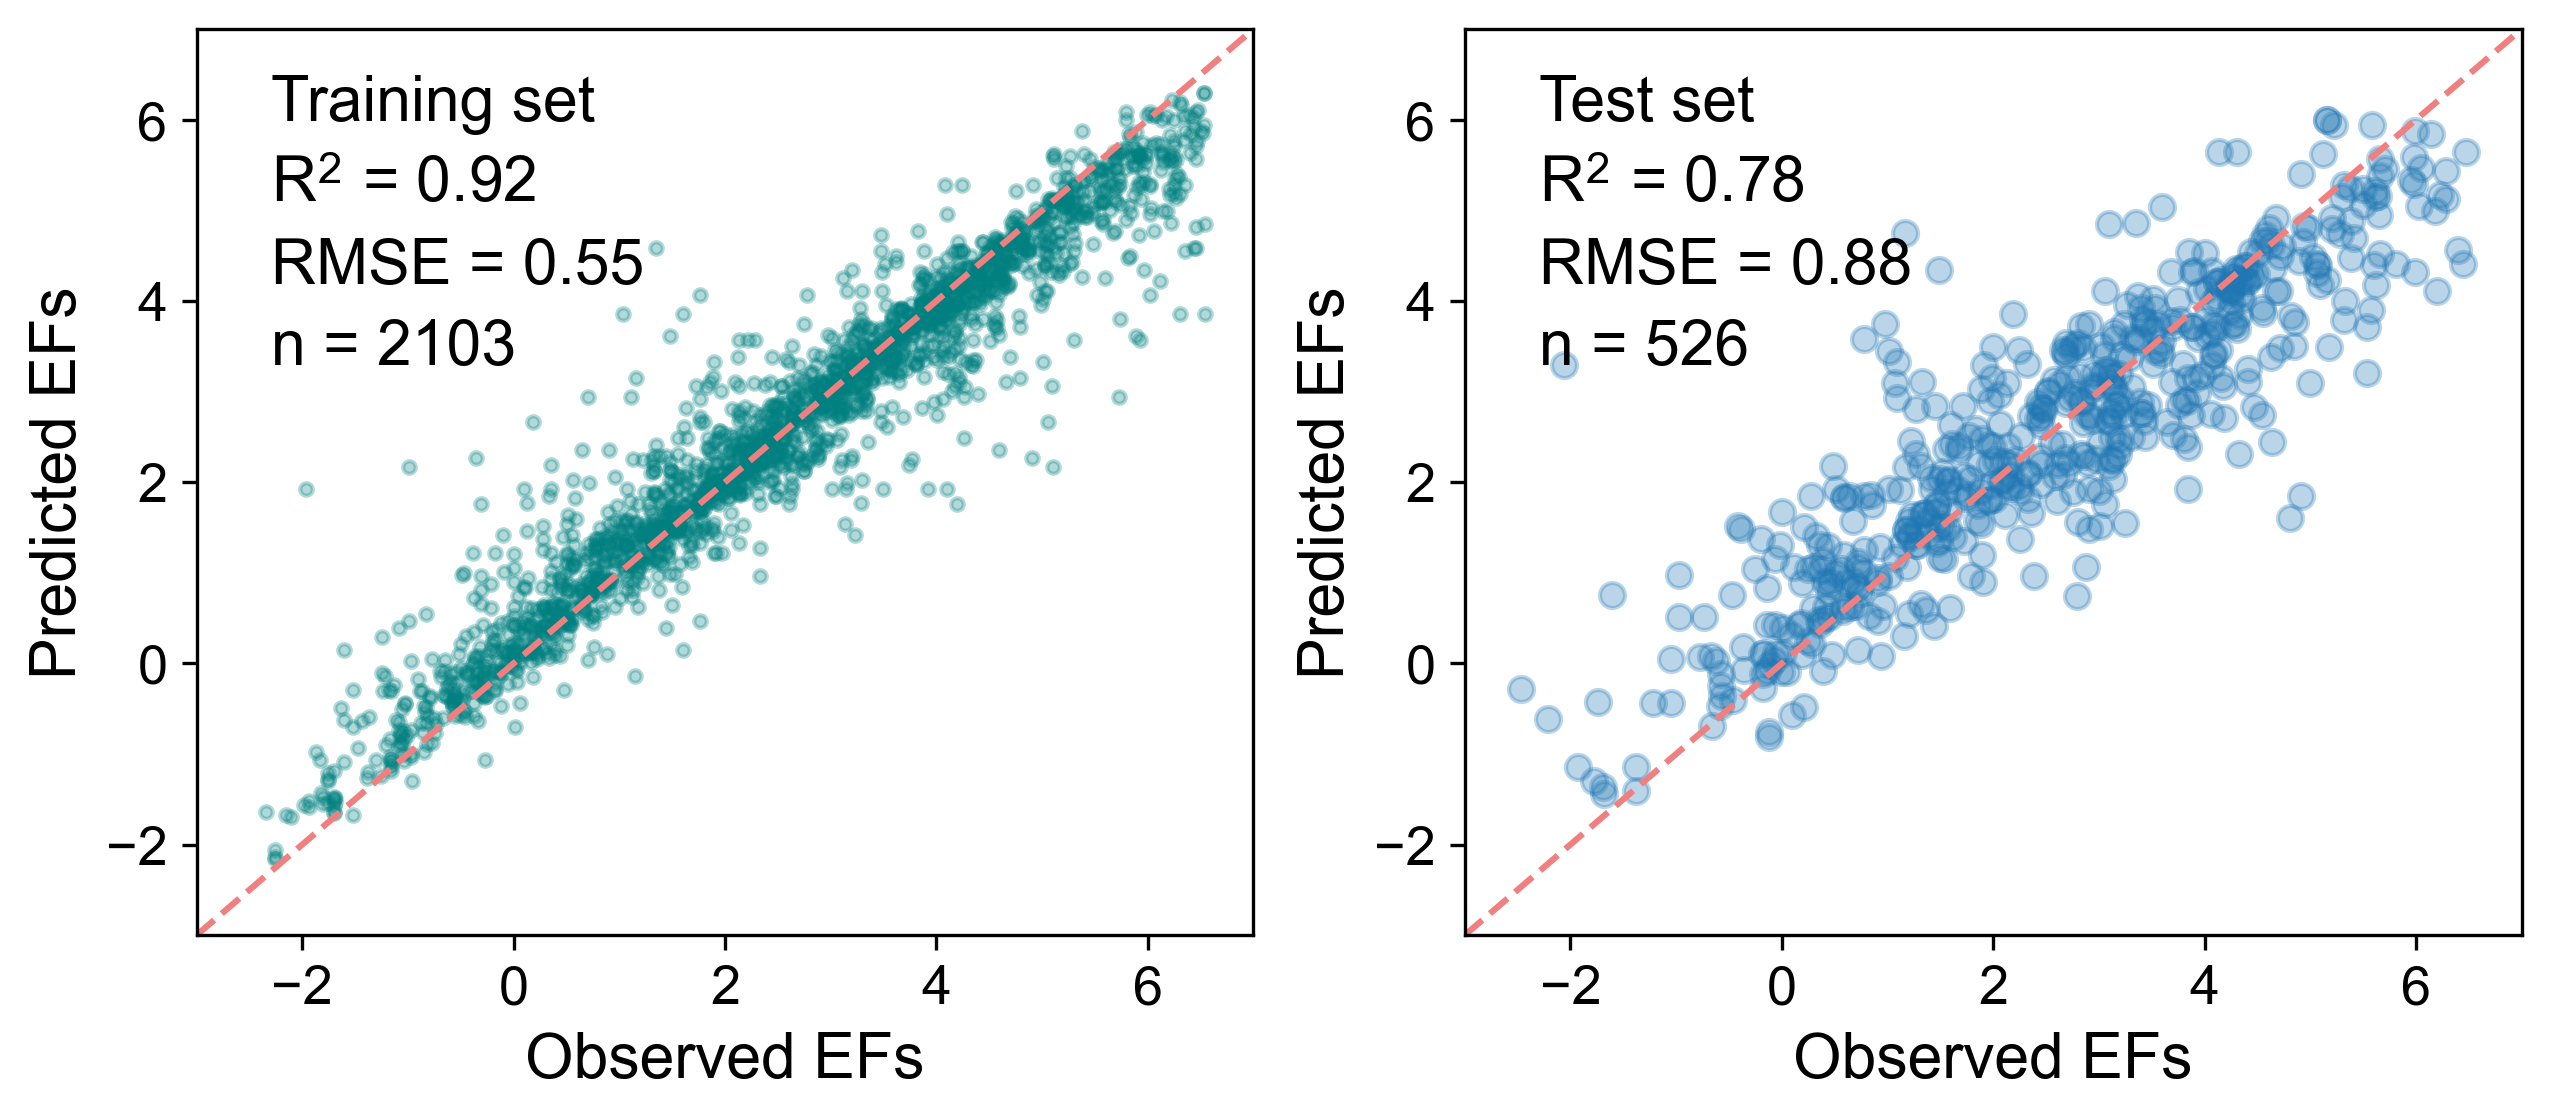

In [108]:
plt.figure(figsize=(10,4),dpi=300)
plt.rc('font',family='Arial')  

plt.subplot(1, 2, 1)
plt.scatter(y_train, RF.predict(x_train), marker = '.', c = "teal",alpha=0.3)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='lightcoral', label="1:1 line",lw = 1.5)
plt.xlabel('Observed EFs', fontsize=15)  
plt.ylabel('Predicted EFs', fontsize=15)  
plt.text(-2.3, 6, 'Training set', fontsize=15)
plt.text(-2.3, 5.1, 'R$\mathregular{^2}$ = ' + str(round(RF.score(x_train, y_train), 2)), fontsize=15)
plt.text(-2.3, 4.2, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(RF.predict(x_train), y_train)),2)), fontsize=15)
#plt.text(-2.3, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_train), y_train),2)), fontsize=15)
plt.text(-2.3, 3.3, 'n = ' + str(x_train.shape[0]), fontsize=15)
plt.tick_params(labelsize=13)  
plt.xlim((-3, 7))
plt.ylim((-3, 7))

plt.subplot(1, 2, 2)
plt.scatter(y_test, RF.predict(x_test),alpha=0.3)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='lightcoral', label="1:1 line",lw = 1.5)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
plt.xlabel('Observed EFs', fontsize=15)  
plt.ylabel('Predicted EFs', fontsize=15) 
plt.text(-2.3, 6, 'Test set', fontsize=15)
plt.text(-2.3, 5.1, 'R$\mathregular{^2}$ = ' + str(round(RF.score(x_test, y_test), 2)), fontsize=15)
plt.text(-2.3, 4.2, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(RF.predict(x_test), y_test)),2)), fontsize=15)
#plt.text(-2.3, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
plt.text(-2.3, 3.3, 'n = ' + str(x_test.shape[0]), fontsize=15)
plt.tick_params(labelsize=13)  
plt.xlim((-3, 7))
plt.ylim((-3, 7))
plt.savefig('./RF_performance.png', dpi = 1000,bbox_inches = 'tight') 